In [164]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.option_context('mode.use_inf_as_na', True)

In [92]:
loc_input_files = os.path.join('..', 'data', 'input')

dfs = list()
for filename in os.listdir(loc_input_files):
    df = pd.read_csv(os.path.join(loc_input_files,filename))
    df['datum'] = filename.strip('.csv')
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)
df = df_raw.copy()

In [93]:
def clean_df(df):

    df = df.rename(columns={'verwachte datum': 'verwachte_datum'})

    # df_wrong met verkeerde datum (29 februari)
    outlier_datums = ['2019-2-29','2019-1-1', '2019-7-1']
    df_wrong = df.loc[df['datum'].isin(outlier_datums)].copy()

    # Verwijder rijen met verkeerde datums
    df = df.loc[~df['datum'].isin(outlier_datums)].copy()
    
    df['dag_van_jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte_datum'] = pd.to_datetime(df['verwachte_datum'], format='%m/%d/%Y')# .dt.strftime('%Y-%m-%d')
    df['datum'] = pd.to_datetime(df['datum'])# .dt.strftime('%Y-%m-%d')

    categories_day = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday', 
              'Friday', 
              'Saturday', 
              'Sunday']

    # Convert 'Day of Week' to a categorical type
    df['weekdag'] = (pd.to_datetime(df['datum']).dt.day_name())
    df['weekdag'] = (pd.Categorical(df['weekdag'], 
                                    categories=categories_day, 
                                    ordered=True))

    categories_month = ['January',
                        'February',
                        'March',
                        'April',
                        'May',
                        'June',
                        'July',
                        'August',
                        'September',
                        'October',
                        'November',
                        'December']

    # Convert 'Month' to a categorical type
    df['maand_naam'] = (pd.to_datetime(df['datum']).dt.month_name())
    df['maand_naam'] = (pd.Categorical(df['maand_naam'], 
                                    categories=categories_month, 
                                    ordered=True))

    df['verschil_dagen'] = (df['verwachte_datum'] - df['datum']).dt.days

    vertaling_dagen = {'Monday': 'Maandag',
                'Tuesday': 'Dinsdag',  
                'Wednesday': 'Woensdag', 
                'Thursday': 'Donderdag', 
                'Friday': 'Vrijdag', 
                'Saturday': 'Zaterdag', 
                'Sunday': 'Zondag'}

    vertaling_maanden = {'January':'Januari',
                'February':'Februari',
                'March':'Maart',
                'April':'April',
                'May':'Mei',
                'June':'Juni',
                'July':'Juli',
                'August':'Augustus',
                'September':'September',
                'October':'Oktober',
                'November':'November',
                'December':'December'}
    
    df['maand_naam'] = df['maand_naam'].cat.rename_categories(vertaling_maanden)
    df['weekdag'] = df['weekdag'].cat.rename_categories(vertaling_dagen)

    df['absolute_verschil_dagen'] = df['verschil_dagen'].abs()

    return df, df_wrong

In [94]:
geboortes, df_wrong = clean_df(df)

In [95]:
geboortes.head()

,gemeente,naam,geslacht,verwachte_datum,datum,dag_van_jaar,weekdag,maand_naam,verschil_dagen,absolute_verschil_dagen
534,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,Donderdag,Januari,-6,6
535,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,Donderdag,Januari,0,0
536,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,Donderdag,Januari,11,11
537,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,Donderdag,Januari,5,5
538,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,Donderdag,Januari,6,6


### potentiele vragen

- kans dat baby te vroeg of te laat geboren wordt?
- Is een bepaalde kindernaam al in gebruik in desbetreffende gemeente? (functie om dit te checken)
- Zijn er in een specifieke gemeente meer of minder geboortes in bepaalde maanden?
- Zijn er in een specifieke gemeente meer of minder jongens/meisjes geboren?
- Zijn er in een specifieke maand meer of minder jongens/meisjes geboren?

In [96]:
# kans dat een baby te laat geboren wordt
p_vroeg = len(geboortes.loc[geboortes['verschil_dagen'] < 0]) / len(geboortes)
print(f'Kans dat een baby te laat geboren wordt: {p_vroeg:.2%}')

# kans dat een baby te vroeg geboren wordt
p_te_laat = len(geboortes.loc[geboortes['verschil_dagen'] > 0]) / len(geboortes)
print(f'Kans dat een baby te vroeg geboren wordt: {p_te_laat:.2%}')

# kans dat een baby op tijd geboren wordt
p_op_tijd = len(geboortes.loc[geboortes['verschil_dagen'] == 0]) / len(geboortes)
print(f'Kans dat een baby op tijd geboren wordt: {p_op_tijd:.2%}')

# gemiddelde aantal dagen te laat
gemiddeld_te_vroeg = geboortes.loc[geboortes['verschil_dagen'] < 0]['verschil_dagen'].mean()
print(f'Gemiddeld aantal dagen te laat: {gemiddeld_te_vroeg:.2f}')

# gemiddelde aantal dagen te vroeg
gemiddeld_te_laat = geboortes.loc[geboortes['verschil_dagen'] > 0]['verschil_dagen'].mean()
print(f'Gemiddeld aantal dagen te vroeg: {gemiddeld_te_laat:.2f}')

# gemiddelde aantal dagen op tijd
gemiddeld_op_tijd = geboortes.loc[geboortes['verschil_dagen'] == 0]['verschil_dagen'].mean()
print(f'Gemiddeld aantal dagen op tijd: {gemiddeld_op_tijd:.2f}')


Kans dat een baby te laat geboren wordt: 17.14%
Kans dat een baby te vroeg geboren wordt: 80.02%
Kans dat een baby op tijd geboren wordt: 2.84%
Gemiddeld aantal dagen te laat: -3.49
Gemiddeld aantal dagen te vroeg: 10.03
Gemiddeld aantal dagen op tijd: 0.00


In [97]:
# Is een bepaalde kindernaam al in gebruik in desbetreffende gemeente

def check_naam(df, naam, gemeente):
    naam = naam.title()
    gemeente = gemeente.title()
    naam_in_gebruik = df.loc[(df['naam'] == naam) & (df['gemeente'] == gemeente)]
    return naam_in_gebruik

naam = 'Tinne'
gemeente = 'Turnhout'
naam_in_gebruik = check_naam(geboortes, naam, gemeente)

if len(naam_in_gebruik) > 0:
    print(f'De naam {naam} is al in gebruik in {gemeente}')
else:
    print(f'De naam {naam} is nog niet in gebruik in {gemeente}')



De naam Tinne is al in gebruik in Turnhout


In [98]:
# in welke gemeente is een bepaalde naam het populairst

def populairste_naam(df, naam):
    naam = naam.title()
    populairste_naam = df.loc[df['naam'] == naam].groupby('gemeente').size().idxmax()
    return populairste_naam

naam = 'Tinne'
populairste_naam = populairste_naam(geboortes, naam)
print(f'De naam {naam} is het populairst in {populairste_naam}')

De naam Tinne is het populairst in Antwerpen


In [99]:
# gemeentes waar een bepaalde naam niet voorkomt

def naam_niet_voorkomt(df, naam):
    naam = naam.title()
    gemeentes = df.loc[df['naam'] == naam]['gemeente'].unique()
    gemeentes = set(df['gemeente'].unique()) - set(gemeentes)
    return gemeentes

naam = 'Tinne'
gemeentes = list(naam_niet_voorkomt(geboortes, naam))
print(f'De naam {naam} komt niet voor in de volgende gemeentes: {gemeentes}')
print(f'De naam {naam} komt niet voor in {len(gemeentes)} gemeentes')


De naam Tinne komt niet voor in de volgende gemeentes: ['Villers-Le-Bouillet', 'Saint-Hubert', 'Bekkevoort', 'De Panne', 'Arendonk', 'Ichtegem', 'Lens', 'Zemst', 'Assenede', 'Temse', 'Elsene', 'Rendeux', 'Bertogne', 'Essen', 'Aarschot', 'Duffel', 'Philippeville', 'Nieuwerkerken (Hasselt)', 'Saint-Georges-sur-Meuse', 'Léglise', 'Lubbeek', 'Zedelgem', 'Damme', 'Blegny', 'Havelange', 'Hooglede', 'Destelbergen', 'Tielt (Tielt)', 'Herselt', 'Zonhoven', 'Poperinge', 'Dinant', 'Rumes', 'Chiny', 'Nassogne', 'Vosselaar', 'Houthulst', 'Genk', 'Bredene', 'Tervuren', 'Wezembeek-Oppem', 'Daverdisse', 'Ouffet', 'Ieper', 'Staden', 'Ohey', 'Gistel', 'Herstal', 'Oud-Turnhout', 'Herve', 'Kruibeke', 'La Louvière', 'Lasne', 'Lier', 'Modave', 'Pepinster', 'Erezée', 'Sint-Gillis-Waas', 'De Haan', 'Drogenbos', 'Lanaken', 'Oudsbergen', 'Zoutleeuw', 'Weismes', 'Houyet', 'Zottegem', 'Melle', 'Borsbeek', 'Bilzen', 'Retie', 'Wichelen', 'Boussu', 'Zaventem', 'Aalst (Aalst)', 'Ukkel', 'Kortemark', 'Hastière', 'Mere

In [100]:
# gemeentes waar een bepaalde naam voorkomt

def naam_voorkomt(df, naam):
    naam = naam.title()
    gemeentes = df.loc[df['naam'] == naam]['gemeente'].unique()
    return gemeentes

naam = 'Tinne'
gemeentes = list(naam_voorkomt(geboortes, naam))
print(f'De naam {naam} komt voor in de volgende gemeentes: {gemeentes}')
print(f'De naam {naam} komt voor in {len(gemeentes)} gemeentes. Dit zijn duidelijke de meest geweldige gemeentes.')

De naam Tinne komt voor in de volgende gemeentes: ['Diest', 'Ranst', 'Turnhout', 'Berlaar', 'Beerse', 'Kontich', 'Antwerpen', 'Westerlo', 'Geel', 'Kasterlee', 'Schoten']
De naam Tinne komt voor in 11 gemeentes. Dit zijn duidelijke de meest geweldige gemeentes.


In [101]:
# Zijn er in een specifieke gemeente meer of minder geboortes in bepaalde maanden

def geboortes_per_maand(df, gemeente):
    gemeente = gemeente.title()
    geboortes_per_maand = df.loc[df['gemeente'] == gemeente].groupby('maand_naam', observed = True).size()
    return geboortes_per_maand

gemeente = 'Turnhout'
geboortes_per_maand = geboortes_per_maand(geboortes, gemeente)
print(f'In {gemeente} zijn er de meeste geboortes in de maand {geboortes_per_maand.idxmax()}')
print(f'In {gemeente} zijn er de minste geboortes in de maand {geboortes_per_maand.idxmin()}')

In Turnhout zijn er de meeste geboortes in de maand April
In Turnhout zijn er de minste geboortes in de maand Februari


In [102]:
# Zijn er in een specifieke gemeente meer of minder jongens/meisjes geboren

def geboortes_per_geslacht(df, gemeente):
    gemeente = gemeente.title()
    geboortes_per_geslacht = df.loc[df['gemeente'] == gemeente].groupby('geslacht').size()
    return geboortes_per_geslacht

gemeente = 'Turnhout'
geboortes_per_geslacht = geboortes_per_geslacht(geboortes, gemeente)

if geboortes_per_geslacht['Mannelijk'] > geboortes_per_geslacht['Vrouwelijk']:
    print(f'In {gemeente} zijn er meer jongens geboren')
elif geboortes_per_geslacht['Mannelijk'] < geboortes_per_geslacht['Vrouwelijk']:
    print(f'In {gemeente} zijn er meer meisjes geboren')
else:
    print(f'In {gemeente} zijn er evenveel jongens als meisjes geboren')


In Turnhout zijn er evenveel jongens als meisjes geboren


In [103]:
# Zijn er in een specifieke maand meer of minder jongens/meisjes geboren?

def geboortes_per_geslacht_per_maand(df, maand):
    maand = maand.title()
    geboortes_per_geslacht_per_maand = df.loc[df['maand_naam'] == maand].groupby('geslacht').size()
    return geboortes_per_geslacht_per_maand

maand = 'January'
geboortes_per_geslacht_per_maand = geboortes_per_geslacht_per_maand(geboortes, maand)

if geboortes_per_geslacht_per_maand['Mannelijk'] > geboortes_per_geslacht_per_maand['Vrouwelijk']:
    print(f'In {maand} zijn er meer jongens geboren')
elif geboortes_per_geslacht_per_maand['Mannelijk'] < geboortes_per_geslacht_per_maand['Vrouwelijk']:
    print(f'In {maand} zijn er meer meisjes geboren')
else:
    print(f'In {maand} zijn er evenveel jongens als meisjes geboren')
    

KeyError: 'Mannelijk'

In [ ]:
# Zijn er in een specifieke maand meer of minder jongens/meisjes geboren in een specifieke gemeente?

def geboortes_per_geslacht_per_maand_per_gemeente(df, maand, gemeente):
    maand = maand.title()
    gemeente = gemeente.title()
    geboortes_per_geslacht_per_maand_per_gemeente = df.loc[(df['maand_naam'] == maand) & (df['gemeente'] == gemeente)].groupby('geslacht').size()
    return geboortes_per_geslacht_per_maand_per_gemeente

maand = 'January'
gemeente = 'Turnhout'
geboortes_per_geslacht_per_maand_per_gemeente = geboortes_per_geslacht_per_maand_per_gemeente(geboortes, maand, gemeente)

if geboortes_per_geslacht_per_maand_per_gemeente['Mannelijk'] > geboortes_per_geslacht_per_maand_per_gemeente['Vrouwelijk']:
    print(f'In {maand} zijn er in {gemeente} meer jongens geboren')
elif geboortes_per_geslacht_per_maand_per_gemeente['Mannelijk'] < geboortes_per_geslacht_per_maand_per_gemeente['Vrouwelijk']:
    print(f'In {maand} zijn er in {gemeente} meer meisjes geboren')
else:
    print(f'In {maand} zijn er in {gemeente} evenveel jongens als meisjes geboren')
    

In January zijn er in Turnhout meer meisjes geboren


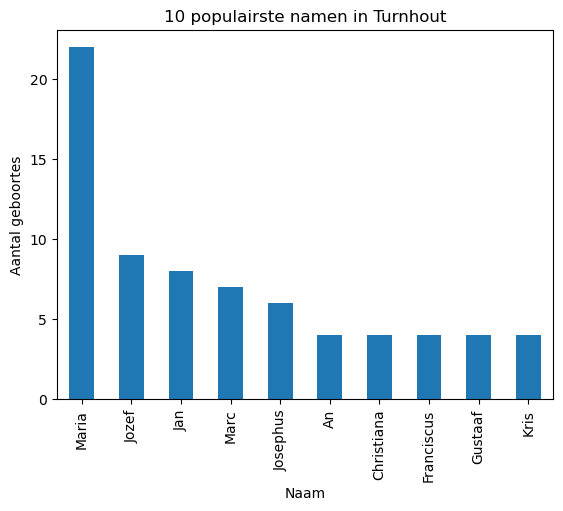

In [ ]:
# plot 10 populairste namen in een specifieke gemeente

def plot_populairste_namen(df, gemeente):
    gemeente = gemeente.title()
    populairste_namen = df.loc[df['gemeente'] == gemeente].groupby('naam').size().nlargest(10)
    populairste_namen.plot(kind='bar')
    plt.title(f'10 populairste namen in {gemeente}')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Naam')
    plt.show()

gemeente = 'Turnhout'
plot_populairste_namen(geboortes, gemeente)

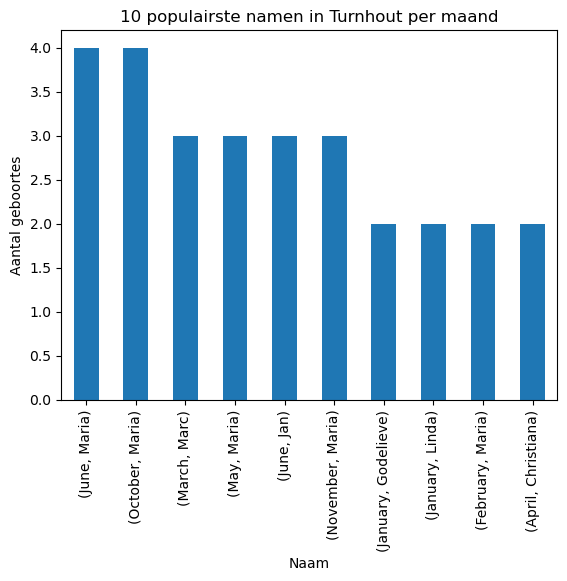

In [ ]:
# plot 10 populairste namen in een specifieke gemeente per maand

def plot_populairste_namen_per_maand(df, gemeente):
    gemeente = gemeente.title()
    populairste_namen_per_maand = df.loc[df['gemeente'] == gemeente].groupby(['maand_naam','naam'], observed = True).size().nlargest(10)
    populairste_namen_per_maand.plot(kind='bar')
    plt.title(f'10 populairste namen in {gemeente} per maand')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Naam')
    plt.show()

gemeente = 'Turnhout'
plot_populairste_namen_per_maand(geboortes, gemeente)

In [ ]:
# namen waar zowel Mannelijk als Vrouwelijk kan voorkomen. Enkel Mannelijk of Vrouwelijk kan in de kolom geslacht aanwezig zijn

def find_unisex_names(df):
    # Group by 'naam' and find the unique values in 'geslacht' for each name
    geslacht_groups = df.groupby('naam')['geslacht'].nunique()

    # Filter for names that have more than one unique value in 'geslacht'
    unisex_names = geslacht_groups[geslacht_groups > 1].index

    return list(unisex_names)

unisex_names = find_unisex_names(df)
print(unisex_names)



['Adama', 'Alexis', 'Amel', 'Amine', 'Andrea', 'Andréa', 'Angel', 'Beau', 'Camille', 'Charlie', 'Chris', 'Claude', 'Deniz', 'Dominique', 'Dursun', 'Eden', 'El', 'Flor', 'Gabriele', 'Gwen', 'Hedwig', 'Hilal', 'Ihsan', 'Ilhan', 'Imran', 'Isa', 'Islam', 'Jente', 'Jessy', 'Jitse', 'Jo', 'Joni', 'José', 'Joy', 'Kim', 'Kris', 'Lenny', 'Leslie', 'Loeka', 'Lou', 'Louka', 'Luca', 'Luka', 'Marian', 'Mattia', 'Maxime', 'Merlin', 'Michele', 'Nicky', 'Niki', 'Nikita', 'Nikola', 'Noa', 'Noor', 'Nour', 'Rabia', 'Rayan', 'Robin', 'Rosario', 'Sacha', 'Sai', 'Sam', 'Sandy', 'Sanne', 'Sasha', 'Senna', 'Simone', 'Tenzin', 'Toby', 'Vivian', 'Yan', 'Yannick', 'Yentl', 'Yi', 'Yoni']


In [ ]:
geslacht_groups = df.groupby('naam')['geslacht'].nunique().sort_values(ascending=False)
geslacht_groups

naam
Hedwig        2
Joy           2
Sam           2
Merlin        2
Islam         2
             ..
Ghislain      1
Gheorghita    1
Gheorghe      1
Ghariba       1
Ümit          1
Name: geslacht, Length: 5256, dtype: int64

In [ ]:
# in welke steden komen universele namen het meeste voor

def unisex_names_per_gemeente(df):
    unisex_names_per_gemeente = df.loc[df['naam'].isin(unisex_names)].groupby('gemeente').size().nlargest(20)
    return unisex_names_per_gemeente

unisex_names_per_gemeente = unisex_names_per_gemeente(geboortes)
unisex_names_per_gemeente

gemeente
Antwerpen                      155
Gent                            90
Charleroi                       75
Luik                            63
Brussel                         59
Bergen                          47
Namen                           46
Ukkel                           36
Leuven                          35
Schaarbeek                      31
Sint-Jans-Molenbeek             31
Anderlecht                      30
Seraing                         29
Aalst (Aalst)                   27
Brugge                          27
Elsene                          24
Mechelen                        23
Doornik                         22
Genk                            21
Sint-Niklaas (Sint-Niklaas)     20
dtype: int64

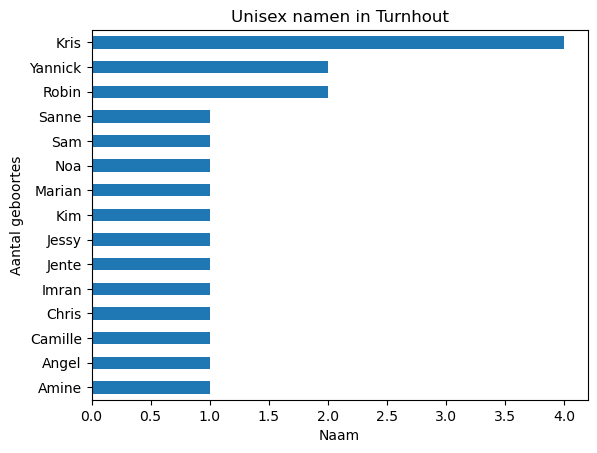

In [ ]:
# plot unisex namen in een specifieke gemeente

def plot_populairste_unisex_namen(df, gemeente):
    gemeente = gemeente.title()
    populairste_unisex_namen = df.loc[(df['gemeente'] == gemeente) & (df['naam'].isin(unisex_names))].groupby('naam').size().sort_values()
    populairste_unisex_namen.plot(kind='barh')
    plt.title(f'Unisex namen in {gemeente}')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Naam')
    plt.show()

gemeente = 'Turnhout'
plot_populairste_unisex_namen(geboortes, gemeente)



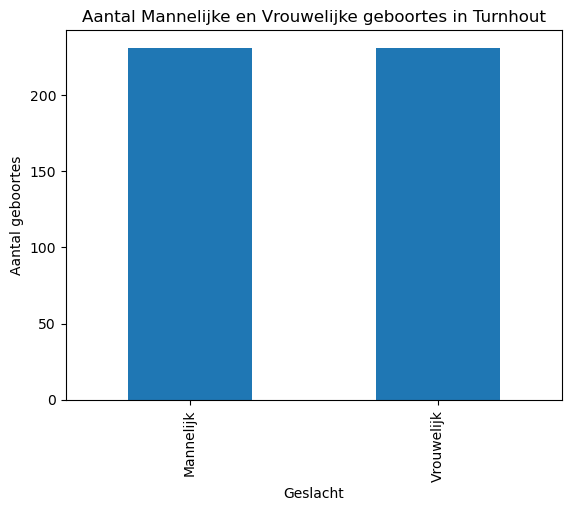

In [ ]:
# aantal Mannelijke en Vrouwelijke geboortes per gemeente

def geboortes_per_geslacht_per_gemeente(df):
    geboortes_per_geslacht_per_gemeente = df.groupby(['gemeente','geslacht']).size()
    return geboortes_per_geslacht_per_gemeente

geboortes_per_geslacht_per_gemeente = geboortes_per_geslacht_per_gemeente(geboortes)
geboortes_per_geslacht_per_gemeente

# plot aantal Mannelijke en Vrouwelijke geboortes per gemeente

def plot_geboortes_per_geslacht_per_gemeente(df, gemeente):
    geboortes_per_geslacht_per_gemeente = df.loc[df['gemeente'] == gemeente].groupby('geslacht').size()
    geboortes_per_geslacht_per_gemeente.plot(kind='bar')
    plt.title(f'Aantal Mannelijke en Vrouwelijke geboortes in {gemeente}')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Geslacht')
    plt.show()

gemeente = 'Turnhout'
plot_geboortes_per_geslacht_per_gemeente(geboortes, gemeente)



In [ ]:
# welke steden zitten er verste naast geschatte geboortedatum

geboortes_per_gemeente = geboortes.groupby('gemeente').size()
verschil_dagen_per_gemeente = geboortes.groupby(['gemeente','geslacht'])['absolute_verschil_dagen'].mean().reset_index()

verschil_dagen_per_gemeente['geboortes_per_gemeente'] = verschil_dagen_per_gemeente['gemeente'].map(geboortes_per_gemeente)
verschil_dagen_per_gemeente['%_verschil_dagen'] = verschil_dagen_per_gemeente['absolute_verschil_dagen'] / verschil_dagen_per_gemeente['geboortes_per_gemeente']*100	
verschil_dagen_per_gemeente

,gemeente,geslacht,absolute_verschil_dagen,geboortes_per_gemeente,%_verschil_dagen
0,Aalst (Aalst),Mannelijk,8.206383,936,0.876750
1,Aalst (Aalst),Vrouwelijk,8.660944,936,0.925315
2,Aalter,Mannelijk,8.068966,291,2.772840
3,Aalter,Vrouwelijk,8.328767,291,2.862119
4,Aarlen,Mannelijk,8.281250,262,3.160782
...,...,...,...,...,...
1153,Zwevegem,Vrouwelijk,7.504000,262,2.864122
1154,Zwijndrecht,Mannelijk,7.473118,170,4.395952
1155,Zwijndrecht,Vrouwelijk,10.883117,170,6.401833
1156,’s Gravenbrakel,Mannelijk,8.086957,207,3.906742


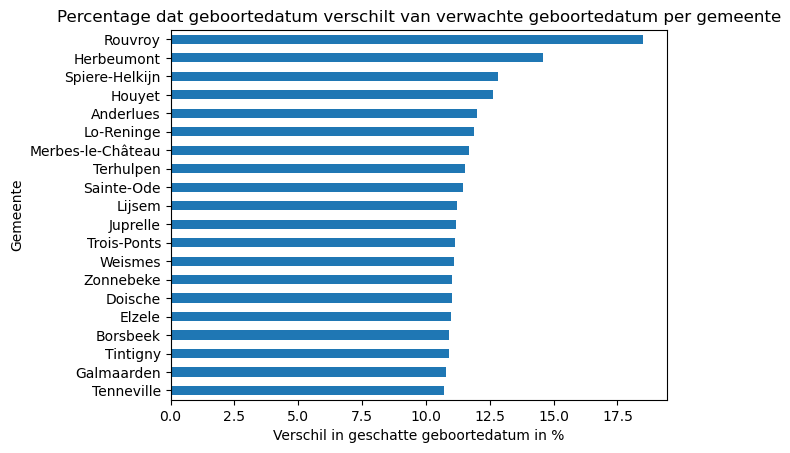

In [ ]:
# plot verste naast geschatte geboortedatum

def plot_verste_naast_geschatte_geboortedatum(df):
    verschil_dagen_per_gemeente = df.groupby('gemeente')['absolute_verschil_dagen'].mean().nlargest(20).sort_values()
    verschil_dagen_per_gemeente.plot(kind='barh')
    plt.title('Percentage dat geboortedatum verschilt van verwachte geboortedatum per gemeente')
    plt.ylabel('Gemeente')
    plt.xlabel('Verschil in geschatte geboortedatum in %')
    plt.show()

plot_verste_naast_geschatte_geboortedatum(geboortes)


d:\Anaconda\envs\ds_absyntra\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


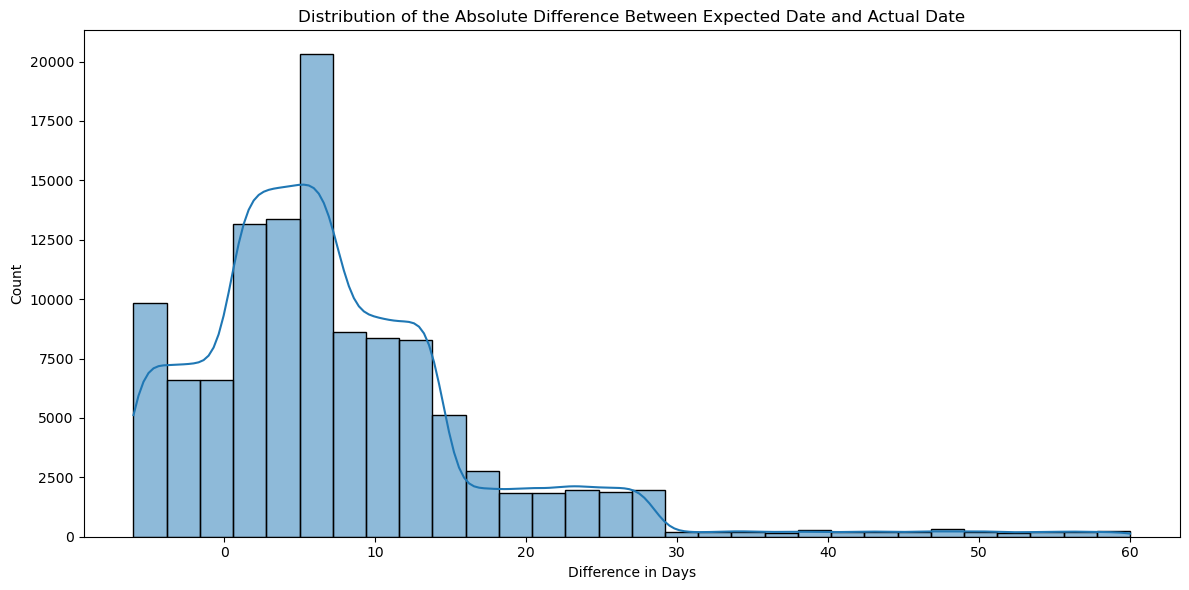

In [155]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(geboortes['verschil_dagen'], bins=30, kde=True, ax = ax)
plt.title('Distribution of the Absolute Difference Between Expected Date and Actual Date')
plt.xlabel('Difference in Days')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [144]:
dagen_over_tijd = 5

# Aantal geboortes
aantal_geboortes = len(geboortes)

# Aantal geboortes zoveel dagen over tijd
aantal_over_tijd = len(geboortes[geboortes['verschil_dagen'] >= 5])

# Kans berekenen
kans = aantal_over_tijd / aantal_geboortes * 100

print(f"De kans dat een geboorte {dagen_over_tijd} dagen over tijd is, is {round(kans, 2)}%")

De kans dat een geboorte 5 dagen over tijd is, is 57.02%


In [152]:
def calculate_chance(df, gemeente, dagen_over_tijd):
    # Filter the DataFrame for the specified 'gemeente'
    df_gemeente = df[df['gemeente'] == gemeente]

    # Calculate the total number of births and the number of births over time
    aantal_geboortes = len(df_gemeente)
    aantal_over_tijd = len(df_gemeente[df_gemeente['verschil_dagen'] >= dagen_over_tijd])

    # Calculate the chance
    kans = aantal_over_tijd / aantal_geboortes * 100

    return kans

gemeente = 'Turnhout'
dagen_over_tijd = 60
kans = calculate_chance(geboortes, gemeente, dagen_over_tijd)

print(f"De kans dat een geboorte {dagen_over_tijd} dagen over tijd is in {gemeente}, is {round(kans, 2)}%")

De kans dat een geboorte 60 dagen over tijd is in Turnhout, is 0.22%


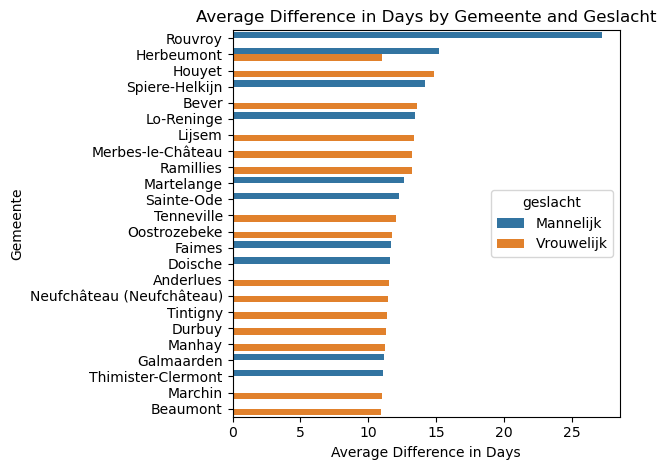

In [209]:
# Calculate the average difference between expected date and actual date, grouped by gender and municipality


mean_diff_days = geboortes.groupby(['gemeente', 'geslacht'])['verschil_dagen'].mean().reset_index().sort_values('verschil_dagen', ascending=False).head(25)

# Plot the data
sns.barplot(data=mean_diff_days, x='verschil_dagen', y='gemeente', hue='geslacht')
plt.title('Average Difference in Days by Gemeente and Geslacht')
plt.xlabel('Average Difference in Days')
plt.ylabel('Gemeente')
plt.tight_layout()
plt.show()

d:\Anaconda\envs\ds_absyntra\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\ds_absyntra\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


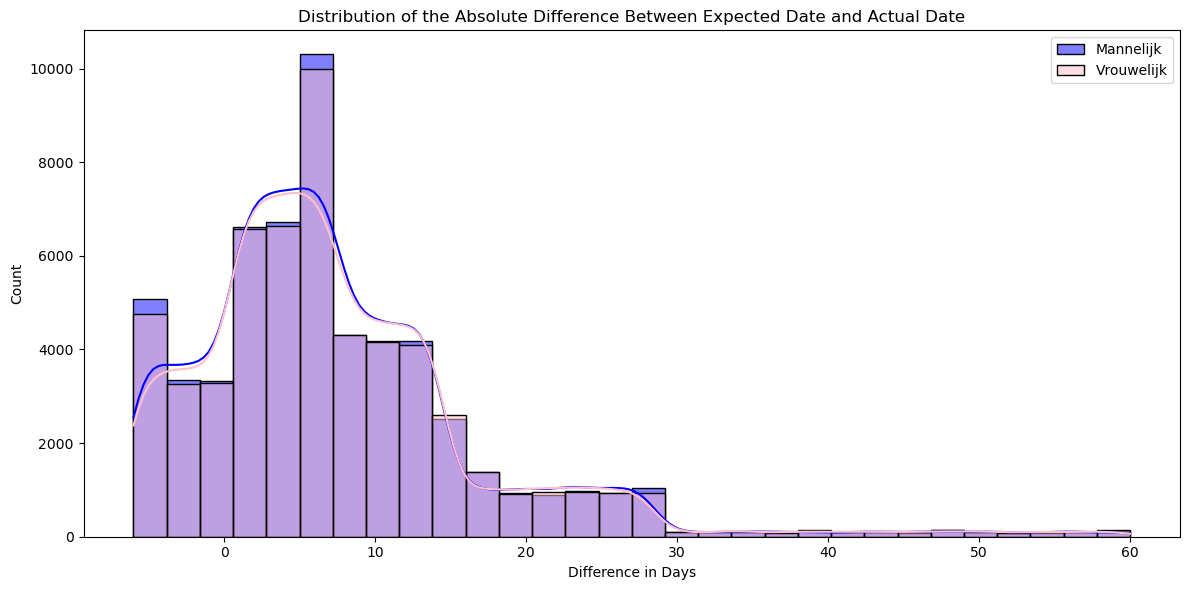

In [162]:
verschil_mannelijk = geboortes.loc[geboortes['geslacht'] == 'Mannelijk']['verschil_dagen']
verschil_vrouwelijk = geboortes.loc[geboortes['geslacht'] == 'Vrouwelijk']['verschil_dagen']

fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(verschil_mannelijk, bins=30, kde=True, color='blue', label='Mannelijk', ax=ax)
sns.histplot(verschil_vrouwelijk, bins=30, kde=True, color='pink', label='Vrouwelijk', ax=ax)
plt.title('Distribution of the Absolute Difference Between Expected Date and Actual Date')

plt.xlabel('Difference in Days')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


d:\Anaconda\envs\ds_absyntra\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\ds_absyntra\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


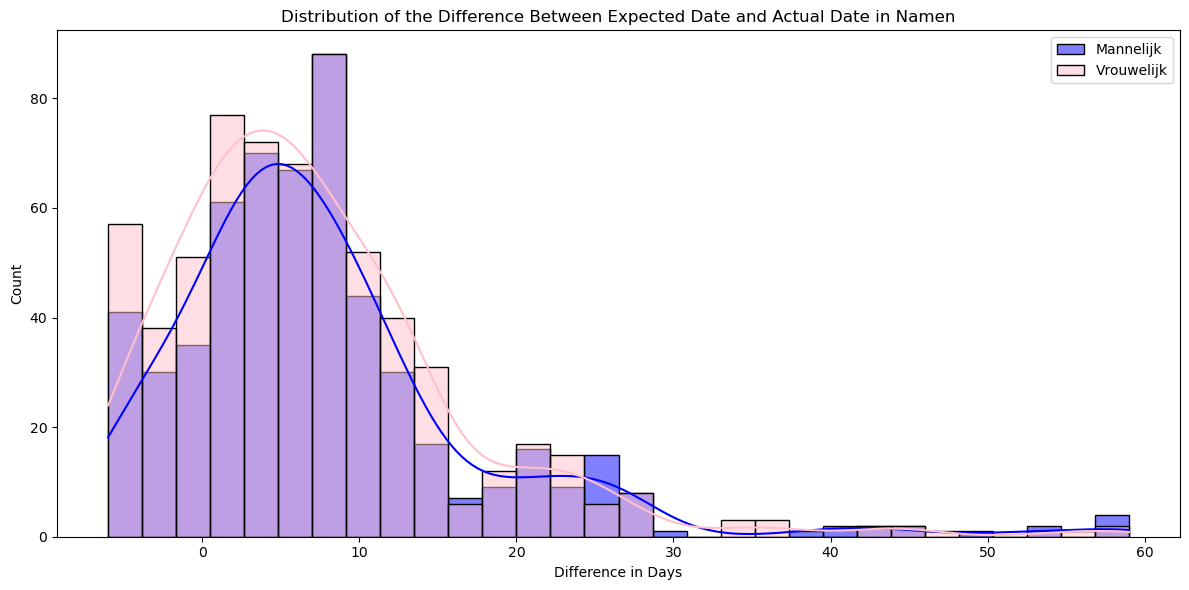

In [208]:
def plot_distribution(df, gemeente):
    # Filter the DataFrame for the specified 'gemeente'
    
    df_gemeente = df[df['gemeente'] == gemeente]

    verschil_mannelijk = df_gemeente.loc[df_gemeente['geslacht'] == 'Mannelijk']['verschil_dagen']
    verschil_vrouwelijk = df_gemeente.loc[df_gemeente['geslacht'] == 'Vrouwelijk']['verschil_dagen']

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.histplot(verschil_mannelijk, bins=30, kde=True, color='blue', label='Mannelijk', ax=ax)
    sns.histplot(verschil_vrouwelijk, bins=30, kde=True, color='pink', label='Vrouwelijk', ax=ax)
    plt.title(f'Distribution of the Difference Between Expected Date and Actual Date in {gemeente}')

    plt.xlabel('Difference in Days')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

gemeente = 'Namen'
plot_distribution(geboortes, gemeente)

In [203]:
verschil_geboortes = geboortes.groupby('gemeente')['geslacht'].value_counts().unstack()
verschil_geboortes['verschil'] = verschil_geboortes['Mannelijk'] - verschil_geboortes['Vrouwelijk']
verschil_geboortes = verschil_geboortes.reset_index()
verschil_geboortes

geslacht,gemeente,Mannelijk,Vrouwelijk,verschil
0,Aalst (Aalst),470,466,4
1,Aalter,145,146,-1
2,Aarlen,128,134,-6
3,Aarschot,159,162,-3
4,Aartselaar,68,51,17
...,...,...,...,...
574,Zutendaal,36,24,12
575,Zwalm,34,30,4
576,Zwevegem,137,125,12
577,Zwijndrecht,93,77,16
